## Experiment Discription

In this experiment, we use fixed layers. We are trying to change $\frac{\alpha}{\beta}$ and ratio style images and see the effect on different styles.

In [1]:
# neural style transfer structure
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv




device = 'cuda' if torch.cuda.is_available() else 'cpu' 




def getimage(image_path,image_size=(512,512)):
    transform = tv.transforms.Compose([
            tv.transforms.Resize(image_size),
            tv.transforms.ToTensor(),
            ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img[None,:,:,:]
    return img.to(device, torch.float)




def myimshow(image, title,save=False,ax=plt):
    fig=plt.figure()  
    image = image.squeeze(0) 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    h = ax.imshow(image) 
    ax.title(title)
    ax.axis('off') 
    
    if save:
        fig.savefig('{}.jpg'.format(title))
    return h

class NormalizeModule(nn.Module):
    def __init__(self):
        super(NormalizeModule, self).__init__()
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)

    def forward(self, x):
        f = (x - self.mean) / self.std
        return f


class ClossModule(nn.Module):

    def __init__(self, f_content,):
        super(ClossModule, self).__init__()
        self.f_content = f_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.f_content)
        return x

def gram_matrix(x):
        B, N, W, H = x.size()  
        f = x.view(B*N, W*H)  
        G = torch.mm(f, f.t())/(B*N*W*H)  
        return G


class SlossModule(nn.Module):

    def __init__(self, f_style):
        super(SlossModule, self).__init__()
        self.G_style = gram_matrix(f_style).detach()

    def forward(self, x):
        G_input = gram_matrix(x)
        self.loss = F.mse_loss(G_input, self.G_style)
        return x




def getmodel(style_img, content_img,content_layers,style_layers):
    
    vgg = tv.models.vgg19(pretrained=True).features.to(device)
    
    model = nn.Sequential()
    model.add_module('Normalization', NormalizeModule().to(device))

    i = 0  
    j = 0
    m = 0
    n = 0
    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'Conv_{}'.format(i)
        else:
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            j += 1
            name = 'Notconv_{}'.format(j)

        model.add_module(name, layer)

        if name[5:] in str(content_layers):
            m += 1
            f_content = model(content_img).detach()
            Closs = ClossModule(f_content)
            model.add_module("Closs_{}".format(m), Closs)
          

        if name[5:] in str(style_layers):
            n += 1
            f_style = model(style_img).detach()
            Sloss = SlossModule(f_style)
            model.add_module("Sloss_{}".format(n), Sloss)
            
        if m==len(content_layers) and n==len(style_layers):
            break
    return model



def nst(input_img,content_img, style_img,
                       content_layers,style_layers,
                       style_weight=1000000, content_weight=1,tol=np.inf,T=3000,lr=0.001):
    
    model = getmodel(style_img, content_img,content_layers,style_layers)
    optimizer = torch.optim.Adam([input_img.requires_grad_()],lr=lr)
    
    epoch=0
    running_loss=np.inf
    while epoch<T or running_loss>tol:
        optimizer.zero_grad()
        model(input_img)
        style_loss = 0
        content_loss = 0

        for name, module in model.named_children():
            if 'Sloss' in name:
                style_loss += module.loss
            if 'Closs' in name:
                content_loss += module.loss

        loss = style_weight*style_loss + content_weight*content_loss
        loss.backward()

        optimizer.step()
        
        epoch += 1
        running_loss = loss.item()
        if epoch % 300 == 299:
            print("epoch : {}:".format(epoch+1))
            print('Weighted Loss : {}'.format(running_loss))

    input_img.data.clamp_(0, 1)
    return input_img

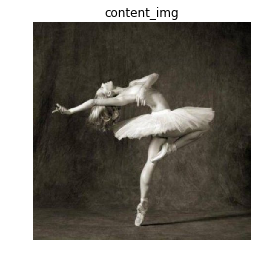

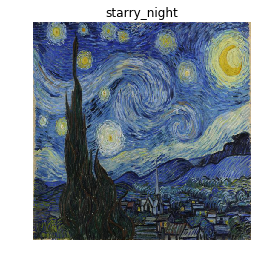

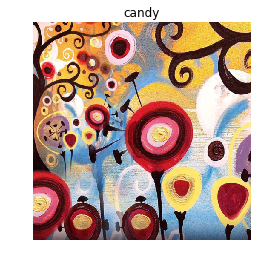

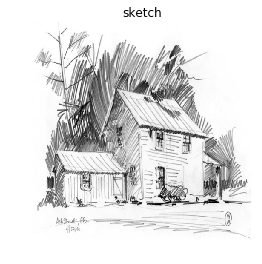

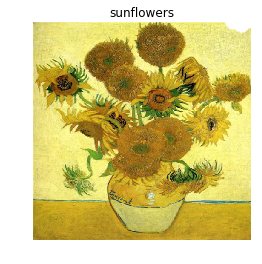

In [3]:
# style_img = getimage('./images/the-starry-night.jpg!Large.jpeg')
style_imgs = ['the-starry-night.jpg!Large.jpeg', 'candy.jpg', 'style_input_2.jpg', 'still-life-vase-with-fifteen-sunflowers-1888-1.jpg!Large.jpeg']
titles = ['starry_night', 'candy', 'sketch', 'sunflowers']
content_img = getimage('./images/dancing.jpg')
# myimshow(style_img,'style_img')
myimshow(content_img,'content_img')
for i in range(4):
    style_img = getimage('./images/'+style_imgs[i])
    myimshow(style_img,titles[i])
    



In [4]:
content_layers_0 = [4]
style_layers_4 = [1,2,3,4]

### 1. ratio  = 1000000

epoch : 300:
Weighted Loss : 23.38275909423828
epoch : 600:
Weighted Loss : 10.037481307983398
epoch : 900:
Weighted Loss : 7.307938575744629
epoch : 1200:
Weighted Loss : 6.734457015991211
epoch : 1500:
Weighted Loss : 6.391850471496582
epoch : 1800:
Weighted Loss : 6.1219377517700195
epoch : 2100:
Weighted Loss : 5.895846366882324
epoch : 2400:
Weighted Loss : 5.7022786140441895
epoch : 2700:
Weighted Loss : 5.5354084968566895
epoch : 3000:
Weighted Loss : 5.392098903656006


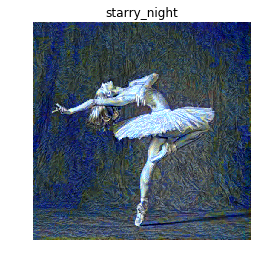

In [14]:

input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[0])
output_1_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
myimshow(output_1_exp1.detach(),titles[0],save=True)

epoch : 300:
Weighted Loss : 64.4345932006836
epoch : 600:
Weighted Loss : 37.49848175048828
epoch : 900:
Weighted Loss : 27.60774803161621
epoch : 1200:
Weighted Loss : 23.47494125366211
epoch : 1500:
Weighted Loss : 21.088346481323242
epoch : 1800:
Weighted Loss : 19.375961303710938
epoch : 2100:
Weighted Loss : 17.968860626220703
epoch : 2400:
Weighted Loss : 16.71428871154785
epoch : 2700:
Weighted Loss : 15.5459566116333
epoch : 3000:
Weighted Loss : 14.441259384155273


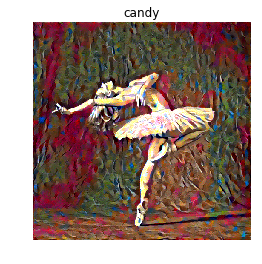

In [13]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[1])
output_1_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
myimshow(output_1_exp2.detach(),titles[1],save=True)

epoch : 300:
Weighted Loss : 77.60688781738281
epoch : 600:
Weighted Loss : 53.3945198059082
epoch : 900:
Weighted Loss : 44.88348388671875
epoch : 1200:
Weighted Loss : 40.559627532958984
epoch : 1500:
Weighted Loss : 37.644744873046875
epoch : 1800:
Weighted Loss : 35.27618408203125
epoch : 2100:
Weighted Loss : 33.11783218383789
epoch : 2400:
Weighted Loss : 31.033336639404297
epoch : 2700:
Weighted Loss : 28.957481384277344
epoch : 3000:
Weighted Loss : 26.852588653564453


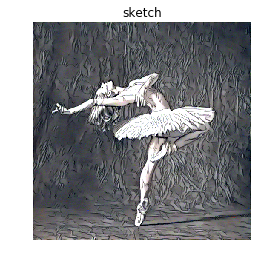

In [15]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[2])
output_1_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
myimshow(output_1_exp3.detach(),titles[2],save=True)

epoch : 300:
Weighted Loss : 52.29621887207031
epoch : 600:
Weighted Loss : 33.66059494018555
epoch : 900:
Weighted Loss : 26.09401512145996
epoch : 1200:
Weighted Loss : 20.703250885009766
epoch : 1500:
Weighted Loss : 16.777185440063477
epoch : 1800:
Weighted Loss : 13.773579597473145
epoch : 2100:
Weighted Loss : 11.308632850646973
epoch : 2400:
Weighted Loss : 9.249213218688965
epoch : 2700:
Weighted Loss : 7.55401611328125
epoch : 3000:
Weighted Loss : 6.208183288574219


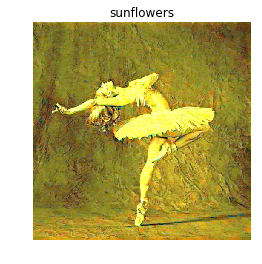

In [16]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[3])
output_1_exp4 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
myimshow(output_1_exp4.detach(),titles[3],save=True)

### 2. ratio = 100000

epoch : 300:
Weighted Loss : 6.381643295288086
epoch : 600:
Weighted Loss : 4.850694179534912
epoch : 900:
Weighted Loss : 4.515478134155273
epoch : 1200:
Weighted Loss : 4.413232803344727
epoch : 1500:
Weighted Loss : 4.353545665740967
epoch : 1800:
Weighted Loss : 4.31070613861084
epoch : 2100:
Weighted Loss : 4.27725076675415
epoch : 2400:
Weighted Loss : 4.249971389770508
epoch : 2700:
Weighted Loss : 4.227063179016113
epoch : 3000:
Weighted Loss : 4.207876682281494


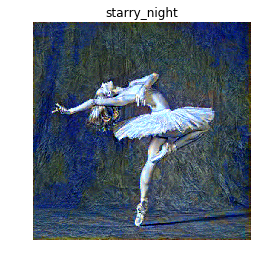

In [5]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[0])
output_2_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
myimshow(output_2_exp1.detach(),titles[0],save=True)

epoch : 300:
Weighted Loss : 12.862811088562012
epoch : 600:
Weighted Loss : 10.004975318908691
epoch : 900:
Weighted Loss : 8.907669067382812
epoch : 1200:
Weighted Loss : 8.404233932495117
epoch : 1500:
Weighted Loss : 8.096203804016113
epoch : 1800:
Weighted Loss : 7.873807430267334
epoch : 2100:
Weighted Loss : 7.694458484649658
epoch : 2400:
Weighted Loss : 7.540381908416748
epoch : 2700:
Weighted Loss : 7.402457237243652
epoch : 3000:
Weighted Loss : 7.276712894439697


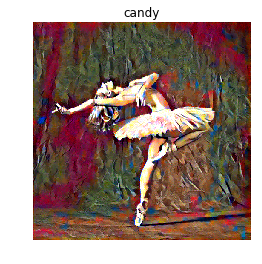

In [6]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[1])
output_2_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
myimshow(output_2_exp2.detach(),titles[1],save=True)

epoch : 300:
Weighted Loss : 12.512781143188477
epoch : 600:
Weighted Loss : 9.775737762451172
epoch : 900:
Weighted Loss : 8.761518478393555
epoch : 1200:
Weighted Loss : 8.22894287109375
epoch : 1500:
Weighted Loss : 7.865299224853516
epoch : 1800:
Weighted Loss : 7.57140588760376
epoch : 2100:
Weighted Loss : 7.309479713439941
epoch : 2400:
Weighted Loss : 7.062456130981445
epoch : 2700:
Weighted Loss : 6.821837425231934
epoch : 3000:
Weighted Loss : 6.583000183105469


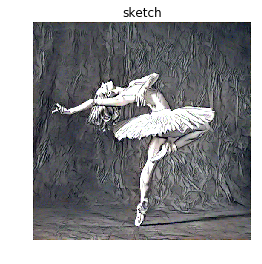

In [7]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[2])
output_2_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
myimshow(output_2_exp3.detach(),titles[2],save=True)

epoch : 300:
Weighted Loss : 7.549063682556152
epoch : 600:
Weighted Loss : 5.577766418457031
epoch : 900:
Weighted Loss : 4.7631635665893555
epoch : 1200:
Weighted Loss : 4.199906349182129
epoch : 1500:
Weighted Loss : 3.796337604522705
epoch : 1800:
Weighted Loss : 3.4866414070129395
epoch : 2100:
Weighted Loss : 3.234750986099243
epoch : 2400:
Weighted Loss : 3.0279831886291504
epoch : 2700:
Weighted Loss : 2.8620858192443848
epoch : 3000:
Weighted Loss : 2.733766555786133


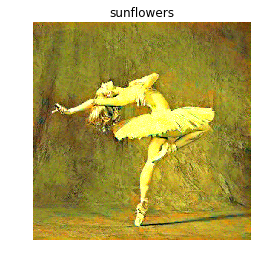

In [8]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[3])
output_2_exp4 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
myimshow(output_2_exp4.detach(),titles[3],save=True)

### 3. ratio = 10000000

epoch : 300:
Weighted Loss : 184.0171356201172
epoch : 600:
Weighted Loss : 51.079769134521484
epoch : 900:
Weighted Loss : 24.666522979736328
epoch : 1200:
Weighted Loss : 20.1328125
epoch : 1500:
Weighted Loss : 17.658729553222656
epoch : 1800:
Weighted Loss : 15.676213264465332
epoch : 2100:
Weighted Loss : 13.969186782836914
epoch : 2400:
Weighted Loss : 12.474039077758789
epoch : 2700:
Weighted Loss : 11.168197631835938
epoch : 3000:
Weighted Loss : 10.039359092712402


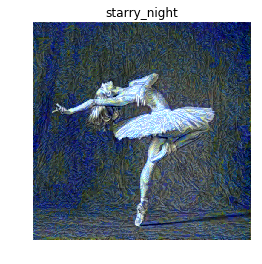

In [9]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[0])
output_3_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000000, content_weight=1)
myimshow(output_3_exp1.detach(),titles[0],save=True)

epoch : 300:
Weighted Loss : 572.0585327148438
epoch : 600:
Weighted Loss : 301.1112976074219
epoch : 900:
Weighted Loss : 201.00860595703125
epoch : 1200:
Weighted Loss : 159.46372985839844
epoch : 1500:
Weighted Loss : 135.86456298828125
epoch : 1800:
Weighted Loss : 119.24453735351562
epoch : 2100:
Weighted Loss : 105.7680892944336
epoch : 2400:
Weighted Loss : 93.82373809814453
epoch : 2700:
Weighted Loss : 82.72808074951172
epoch : 3000:
Weighted Loss : 72.23959350585938


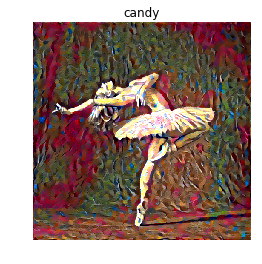

In [10]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[1])
output_3_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000000, content_weight=1)
myimshow(output_3_exp2.detach(),titles[1],save=True)

epoch : 300:
Weighted Loss : 722.7660522460938
epoch : 600:
Weighted Loss : 481.17938232421875
epoch : 900:
Weighted Loss : 396.04595947265625
epoch : 1200:
Weighted Loss : 352.8453063964844
epoch : 1500:
Weighted Loss : 323.9145812988281
epoch : 1800:
Weighted Loss : 300.5922546386719
epoch : 2100:
Weighted Loss : 279.5012512207031
epoch : 2400:
Weighted Loss : 259.19970703125
epoch : 2700:
Weighted Loss : 238.97251892089844
epoch : 3000:
Weighted Loss : 218.43450927734375


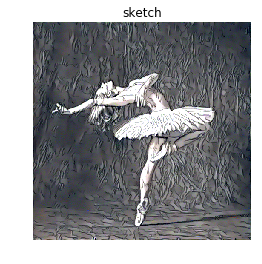

In [11]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[2])
output_3_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000000, content_weight=1)
myimshow(output_3_exp3.detach(),titles[2],save=True)

epoch : 300:
Weighted Loss : 491.9049987792969
epoch : 600:
Weighted Loss : 305.3323974609375
epoch : 900:
Weighted Loss : 230.0993194580078
epoch : 1200:
Weighted Loss : 176.55255126953125
epoch : 1500:
Weighted Loss : 137.68211364746094
epoch : 1800:
Weighted Loss : 108.11402893066406
epoch : 2100:
Weighted Loss : 83.917236328125
epoch : 2400:
Weighted Loss : 63.733428955078125
epoch : 2700:
Weighted Loss : 47.1595344543457
epoch : 3000:
Weighted Loss : 34.06170654296875


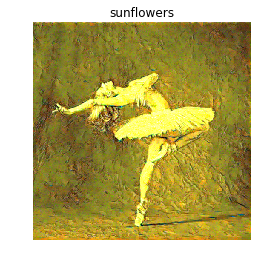

In [12]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[3])
output_3_exp4 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000000, content_weight=1)
myimshow(output_3_exp4.detach(),titles[3],save=True)

### 4. ratio = 100000000

epoch : 300:
Weighted Loss : 1788.9031982421875
epoch : 600:
Weighted Loss : 458.4673156738281
epoch : 900:
Weighted Loss : 193.62539672851562
epoch : 1200:
Weighted Loss : 148.27337646484375
epoch : 1500:
Weighted Loss : 123.68964385986328
epoch : 1800:
Weighted Loss : 104.05561828613281
epoch : 2100:
Weighted Loss : 87.18704223632812
epoch : 2400:
Weighted Loss : 72.4674301147461
epoch : 2700:
Weighted Loss : 59.66236877441406
epoch : 3000:
Weighted Loss : 48.66096115112305


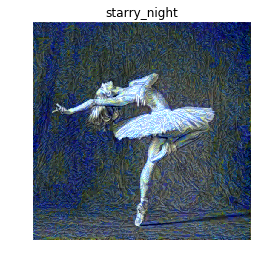

In [13]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[0])
output_4_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000000, content_weight=1)
myimshow(output_4_exp1.detach(),titles[0],save=True)

epoch : 300:
Weighted Loss : 5647.33203125
epoch : 600:
Weighted Loss : 2936.119873046875
epoch : 900:
Weighted Loss : 1932.619384765625
epoch : 1200:
Weighted Loss : 1515.876708984375
epoch : 1500:
Weighted Loss : 1278.745849609375
epoch : 1800:
Weighted Loss : 1111.8994140625
epoch : 2100:
Weighted Loss : 976.6375732421875
epoch : 2400:
Weighted Loss : 856.7219848632812
epoch : 2700:
Weighted Loss : 745.5269775390625
epoch : 3000:
Weighted Loss : 640.451416015625


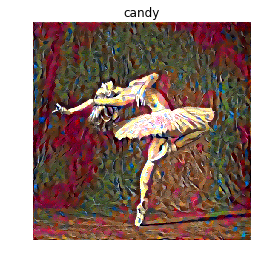

In [14]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[1])
output_4_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000000, content_weight=1)
myimshow(output_4_exp2.detach(),titles[1],save=True)

epoch : 300:
Weighted Loss : 7173.1904296875
epoch : 600:
Weighted Loss : 4758.66357421875
epoch : 900:
Weighted Loss : 3906.376220703125
epoch : 1200:
Weighted Loss : 3473.437255859375
epoch : 1500:
Weighted Loss : 3183.12841796875
epoch : 1800:
Weighted Loss : 2949.238525390625
epoch : 2100:
Weighted Loss : 2737.970947265625
epoch : 2400:
Weighted Loss : 2534.946533203125
epoch : 2700:
Weighted Loss : 2332.488525390625
epoch : 3000:
Weighted Loss : 2126.933349609375


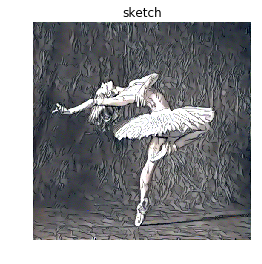

In [15]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[2])
output_4_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000000, content_weight=1)
myimshow(output_4_exp3.detach(),titles[2],save=True)

epoch : 300:
Weighted Loss : 4886.49267578125
epoch : 600:
Weighted Loss : 3018.96240234375
epoch : 900:
Weighted Loss : 2265.3466796875
epoch : 1200:
Weighted Loss : 1728.5897216796875
epoch : 1500:
Weighted Loss : 1338.6346435546875
epoch : 1800:
Weighted Loss : 1042.063232421875
epoch : 2100:
Weighted Loss : 799.3671264648438
epoch : 2400:
Weighted Loss : 597.1144409179688
epoch : 2700:
Weighted Loss : 431.1688537597656
epoch : 3000:
Weighted Loss : 300.266357421875


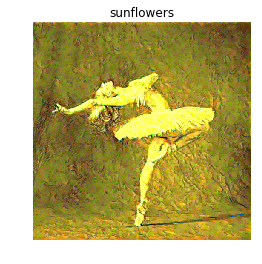

In [16]:
input_img = content_img.clone()
style_img = getimage('./images/'+style_imgs[3])
output_4_exp4 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000000, content_weight=1)
myimshow(output_4_exp4.detach(),titles[3],save=True)